In [1]:
# a few packages we need to import

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython 
import pickle
import random

from itertools import chain,product
from scipy import stats as st
from scipy import special as sp

In [2]:
import optimizer as O

In [4]:
class Trajectory:
    """
    A trajectory consisting of states, corresponding actions, and outcomes.

    Args:
        transitions: The transitions of this trajectory as an array of
            tuples `(state_from, action, state_to)`. Note that `state_to` of
            an entry should always be equal to `state_from` of the next
            entry.
    """
    def __init__(self, transitions):
        self._t = transitions

    def transitions(self):
        """
        The transitions of this trajectory.

        Returns:
            All transitions in this trajectory as array of tuples
            `(state_from, action, state_to)`.
        """
        return self._t

    def states(self):
        """
        The states visited in this trajectory.

        Returns:
            All states visited in this trajectory as iterator in the order
            they are visited. If a state is being visited multiple times,
            the iterator will return the state multiple times according to
            when it is visited.
        """
        return map(lambda x: x[0], chain(self._t, [(self._t[-1][2], 0, 0)]))

    def __repr__(self):
        return "Trajectory({})".format(repr(self._t))

    def __str__(self):
        return "{}".format(self._t)

In [5]:
class DiscretePendulum:
    
    
    def __init__(self, nq=50, nv=50, nu=3, u_max=5, v_max=5.):
        """
        constructor of the class, takes as input desired discretization number
        nq (for angle), nv (for angular velocity) and nu (for control) and the maximum control
        and angular velocity
        """
        #store discretization information
        self.nq=nq
        self.nv=nv
        self.nu = nu
        self.v_max = v_max
        self.m = 1
        self.l = 0.6
        
        self.angle_std = 3*2*np.pi/360
        self.speed_std = 0.1
        
        # create lookup tables for discretized states
        self.u = np.linspace(-u_max, u_max, self.nu)
        self.q = np.linspace(-np.pi, np.pi, self.nq, endpoint=False)
        self.v = np.linspace(-v_max, v_max, self.nv)
        
        #the total number of discretized states
        self.num_states = self.nq * self.nv
        
        #gravity constant
        self.g=9.81

        #discretization step
        self.delta_t = 0.1
        #integration step / smaller than discretization step to ensure stability of integration
        self.dt = 0.1
        self.integration_ratio = int(self.delta_t/self.dt)
        
        # we pre-compute every possible transition and store the index of the transition
        # in a 2D table (for element address the state and second the control)
        self.next_state_index = np.empty([self.num_states, self.nu], dtype=np.int32)
        for i in range(self.num_states):
            for k in range(self.nu):
                x_next = self.step(self.get_states(i), self.u[k])
                self.next_state_index[i,k] = self.get_index(x_next)
        
        
        self.transition_prob = np.zeros([self.num_states, self.nu, self.num_states])
        for _ in range(100):
            for i in range(self.num_states):
                for k in range(self.nu):
                    x_next = self.step(self.get_states(i), self.u[k])
                    next_state_index = self.get_index(x_next)
                    self.transition_prob[i,k,next_state_index] += 1.0
        
        for i in range(self.num_states):
            for k in range(self.nu):
                self.transition_prob[i,k] = self.transition_prob[i,k]/np.sum(self.transition_prob[i,k])
            
            
    def step(self,x,u):
        
        for i in range(self.integration_ratio):
            x_next = (x[0] + self.dt * x[1] + 1.*np.random.normal(0,self.angle_std))
            v_next = np.clip(x[1] + self.dt * (u/(self.m*self.l*self.l) + self.g*np.sin(x[0])/self.l) + 1.*np.random.normal(0,self.speed_std), -self.v_max, self.v_max)
            
            if  x_next < -np.pi: #Angle is modulo 2\pi
                x_next = x_next + 2*np.pi
            if x_next > np.pi:
                x_next = x_next - 2*np.pi
                
            x = np.array([x_next,v_next])
        return x
    
    def simulate(self, x0, policy, T):
       
        horizon_length = int(T/self.delta_t)
        x=np.empty([2, horizon_length+1])
        trajectory = []
        x[:,0] = x0
        u=np.empty([horizon_length])
        for i in range(horizon_length):
            u[i] = np.random.choice(self.u,p=policy[self.get_index(x[:,i])])
            x[:,i+1] = self.step(x[:,i], u[i])
            trajectory+=[(self.get_index(x[:,i]),self.get_u_index(u[i]),self.get_index(x[:,i+1]))]
        return x, u
    
    def generate_trajectories(self, x0, policy, T):
       
        horizon_length = int(T/self.delta_t)
        x=np.empty([2, horizon_length+1])
        trajectory = []
        
        x[:,0] = x0
        u=np.empty([horizon_length])
        for i in range(horizon_length):
            x_sample = np.zeros((2,100))
            u[i] = np.random.choice(self.u,p=policy[self.get_index(x[:,i])])
            for j in range(100):
                x_sample[:,j] = self.step(x[:,i], u[i])
            
            x[:,i+1] = np.mean(np.array(x_sample),axis=1)
            trajectory+=[(self.get_index(x[:,i]),self.get_u_index(u[i]),self.get_index(x[:,i+1]))]
        return Trajectory(trajectory)

    
    def get_index(self, x):
        
        ind_q = np.argmin((x[0]-self.q)**2)
        ind_v = np.argmin((x[1]-self.v)**2)
        return ind_q + ind_v*self.nq
    
    def get_qv_indices(self, x):
        
        ind_q = np.argmin((x[0]-self.q)**2)
        ind_v = np.argmin((x[1]-self.v)**2)
        return ind_q, ind_v
    
    def get_u_index(self, u):

        ind_u = np.argmin((u-self.u)**2)
        return ind_u 
    
    def get_states(self, index):
        
        iv,ix = np.divmod(index, self.nq)
        return np.array([self.q[ix], self.v[iv]])
    
    def get_input(self, index):
        
        iv,ix = np.divmod(index, self.nu)
        return self.u[ix]                   

In [6]:
def cost_descrete(ind,pendulum,theta):
    x = pendulum.get_states(ind)
    return theta[0]*(1-np.exp(-(1-np.cos(x[0]))**2)) + theta[1]*(1-np.exp(-(x[1]**2)))

In [8]:
transition_prob = np.reshape(np.load('plant_l06_m1_new.npy'),(2500,-1,2500))

In [37]:
transition_prob_new = np.reshape(transition_prob,(2500,-1,2500))

In [38]:
class ValueIteration:
    
    def __init__(self, model, cost, discount_factor=0.99):
        
        
        # value function stored as a 1D array (indexed as we indexed states in pendulum)
        self.value_function = np.zeros([model.num_states])
        # we also store the policy similarly
        self.policy = np.zeros([model.num_states])
        # references to the pendulum and cost function
        self.model = model
        self.cost = cost
        
        #discount factor for cost
        self.gamma = discount_factor
                
    def iterate(self, num_iter=1):
        
        for i in range(num_iter):
            J_new = self.value_function.copy()
            for j in range(self.model.num_states):
                #for each possible control input we compute the cost
                r = np.zeros([self.model.nu])
                for l in range(self.model.nu):
                    # the current states and control
                    x = self.model.get_states(j)
                    u = self.model.u[l]
                    # the index for the next state
                    next_index = self.model.next_state_index[j,l]
                    #compute the cost
                    r[l] = self.cost(x, u) + self.gamma*self.value_function[next_index]
                    
                # we take the smallest cost value to update the value function
                J_new[j] = np.max(r)
                #here we also store the policy (so we have it for later)
                self.policy[j] = self.model.u[np.argmax(r)]
                
            #we update the current value function if there is any change otherwise we are done
            if ((self.value_function-J_new)**2 < 10e-3).all():
                print("CONVERGED after iteration " + str(i))
                break
            else:
                self.value_function = J_new.copy()
    

In [39]:
class ValueIteration_S:
    
    def __init__(self, model,cost, p_transition,discount_factor=0.99):
        
        
        # value function stored as a 1D array (indexed as we indexed states in pendulum)
        self.value_function = np.zeros([model.num_states])
        # we also store the policy similarly
        self.policy = np.zeros([model.num_states,model.nu])
        # references to the pendulum and cost function
        self.model = model
        self.cost = cost
        self.p_transition = p_transition
        
        #discount factor for cost
        self.gamma = discount_factor
                
    def iterate(self, num_iter=1):
        
        for i in range(num_iter):
            J_new = self.value_function.copy()
            for j in range(self.model.num_states):
                #for each possible control input we compute the cost
                r = np.zeros([self.model.nu])
                for l in range(self.model.nu):
                    # the current states and control
                    x = self.model.get_states(j)
                    u = self.model.u[l]
                    # the index for the next state
                    #next_index = self.model.next_state_index[j,l]
                    
                    Q = self.model.transition_prob[j,l]*(self.cost + (self.gamma*self.value_function))
                    # C = self.model.transition_prob[j,l]*self.cost
                    #compute the cost
                    r[l] = self.cost[j] + np.sum(Q,axis=0) #+ np.sum(C,axis=0)
                    
                # we take the smallest cost value to update the value function
                J_new[j] = np.argmax(r)
                #here we also store the policy (so we have it for later)
                self.policy[j] = np.exp(r-J_new[j])
                # self.policy[j] = self.model.u[np.argmax(r)]
                
            #we update the current value function if there is any change otherwise we are done
            if ((self.value_function-J_new)**2 < 10e-5).all():
                print("CONVERGED after iteration " + str(i))
                break
            else:
                self.value_function = J_new.copy()
    

In [9]:
class ValueIteration_Soft:
    
    def __init__(self, model,cost, p_transition,discount_factor=0.99):
        
        
        # value function stored as a 1D array (indexed as we indexed states in pendulum)
        self.value_function = np.zeros([model.num_states])
        # we also store the policy similarly
        self.policy = np.zeros([model.num_states,model.nu])
        # references to the pendulum and cost function
        self.model = model
        self.cost = cost
        self.p_transition = p_transition
        
        #discount factor for cost
        self.gamma = discount_factor
                
    def iterate(self, num_iter=1):
        
        for i in range(num_iter):
            J_new = self.value_function.copy()
            for j in range(self.model.num_states):
                #for each possible control input we compute the cost
                r = np.zeros([self.model.nu])
                for l in range(self.model.nu):
                    # the current states and control
                    x = self.model.get_states(j)
                    u = self.model.u[l]
                    
                    #q,v =self.model.get_qv_indices(x)
                    # the index for the next state
                    #next_index = self.model.next_state_index[j,l]
                    
                    Q = self.model.transition_prob[j,l]*(self.cost + (self.gamma*self.value_function))
                    # C = self.model.transition_prob[j,l]*self.cost
                    #compute the cost
                    r[l] = self.cost[j] + np.sum(Q,axis=0) #+ np.sum(C,axis=0)
                    
                # we take the smallest cost value to update the value function
                J_new[j] = sp.logsumexp(r)
                #here we also store the policy (so we have it for later)
                self.policy[j] = np.exp(r-J_new[j])
                
            #we update the current value function if there is any change otherwise we are done
            if ((self.value_function-J_new)**2 < 10e-5).all():
                print("CONVERGED after iteration " + str(i))
                break
            else:
                self.value_function = J_new.copy()
    

In [10]:
# we instantiate a pendulum with discretization 50x50 for angle q and velocity v and 20 actions
# pendulum = DiscretePendulum(nq=50, nv=50, nu=20)

In [11]:
pendulum = DiscretePendulum(nq=50, nv=50, nu=20, u_max=2.5)

In [12]:
def cost_mat(cost,theta):

    cost_m = np.zeros((2500))

    for i in range(2500):
        cost_m[i] = cost(i,pendulum,theta)
    return cost_m

In [13]:
cost_matrix = cost_mat(cost_descrete,[-100,-1.0])

In [165]:
cost_matrix_OG = cost_mat(cost_descrete,[100,1.0])

cost_matrix_MaxEnt = cost_mat(cost_descrete,[137.68,76.68])

cost_matrix_IHMCE = cost_mat(cost_descrete,[150.45,30.43])

cost_matrix_IOC = cost_mat(cost_descrete,[1903.7,3.33])


In [166]:
cost_matrix_OG_norm = cost_matrix_OG/np.sum(cost_matrix_OG)

cost_matrix_ME_norm = cost_matrix_MaxEnt/np.sum(cost_matrix_MaxEnt)

cost_matrix_IHMCE_norm = cost_matrix_IHMCE/np.sum(cost_matrix_IHMCE)

cost_matrix_IOC_norm = cost_matrix_IOC/np.sum(cost_matrix_IOC)

In [167]:
cost_KLD_1 = st.entropy(cost_matrix_OG_norm,cost_matrix_ME_norm)

cost_KLD_2 = st.entropy(cost_matrix_OG_norm,cost_matrix_IHMCE_norm)

cost_KLD_3 = st.entropy(cost_matrix_OG_norm,cost_matrix_IOC_norm)

print('KLD MaxEnt',cost_KLD_1)
print('KLD IHMCE',cost_KLD_2)
print('KLD Alg 2',cost_KLD_3)


KLD MaxEnt 0.12459359717234546
KLD IHMCE 0.0467979210312061
KLD Alg 2 0.0016208070317053319


In [ ]:
# we instanciate a value iteration object for a pendulum model and a cost function
value_iteration = ValueIteration(pendulum, cost)

# we run the iterations
value_iteration.iterate(2000)

In [14]:
# we instanciate a value iteration object for a pendulum model and a cost function
value_iteration = ValueIteration_Soft(pendulum, cost_matrix, transition_prob)

# we run the iterations
value_iteration.iterate(2000)

CONVERGED after iteration 518


In [15]:
u1 = st.uniform(loc=-np.pi,scale=0.5)
u2 = st.uniform(loc=-5.,scale=10.)

traj_len = 301
num_traj = 1
X = np.zeros((2,traj_len,num_traj))
U = np.zeros((traj_len-1,num_traj))
for i in range(num_traj):
    x0 = np.array([u1.rvs(),u2.rvs()])
    x,u = pendulum.simulate(x0, value_iteration.policy, 30)
    X[:,:,i] = x
    U[:,i] = u
    

In [16]:
X_mean = np.mean(X,axis=2)
X_std = np.std(X,axis=2)

U_mean = np.mean(U,axis=1)
U_std = np.std(U,axis=1)

In [17]:
u1 = st.uniform(loc=-np.pi,scale=2*np.pi)
u2 = st.uniform(loc=-5.,scale=10.)

trajectory = [pendulum.generate_trajectories(np.array([u1.rvs(),u2.rvs()]), value_iteration.policy, 30) for i in range(100)]

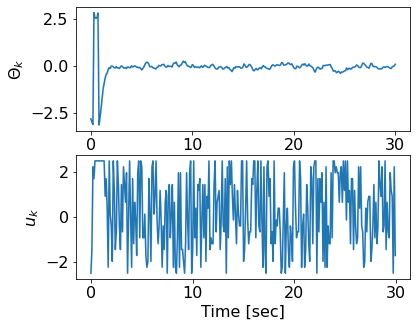

In [18]:
%matplotlib inline
from pylab import rcParams
plt.rcParams.update({'font.size': 16})
time = np.linspace(0.,30., len(x[0,:]))
fig, ax = plt.subplots(2,1)

fig.figure.set_figheight(5)
ax[0].plot(time,X_mean[0,:].T)
#ax.plot(x,y_FPD)
ax[0].fill_between(time, (X_mean[0,:].T-X_std[0,:].T), (X_mean[0,:].T+X_std[0,:].T), color='b', alpha=.1)
#ax.fill_between(x, (y_FPD-ci_FPD), (y_FPD+ci_FPD), color='b', alpha=.1)
#ax.set_title('FPD input')
#ax[0].set_xlabel('Time (Sec)')
ax[0].set_ylabel('$\Theta_{k}$')

ax[1].plot(time[:-1],U_mean)
#ax.plot(x,y_FPD)
ax[1].fill_between(time[:-1], (U_mean.T-U_std.T), (U_mean.T+U_std.T), color='b', alpha=.1)
#ax.fill_between(x, (y_FPD-ci_FPD), (y_FPD+ci_FPD), color='b', alpha=.1)
#ax.set_title('FPD input')
ax[1].set_xlabel('Time [sec]')
ax[1].set_ylabel('$u_{k}$')

plt.show()

# plt.savefig('value_iteration_pendulum_traj.jpg',dpi=1000,bbox_inches ='tight')



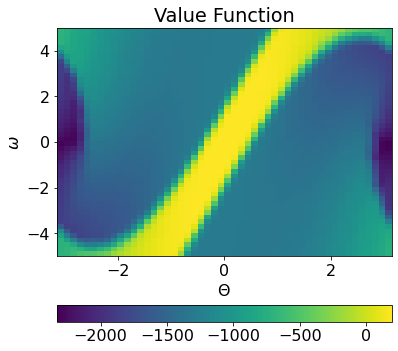

In [19]:
%matplotlib inline
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=[6,6])
im = plt.imshow(value_iteration.value_function.reshape((pendulum.nq, pendulum.nv)), extent=[-np.pi, np.pi, -pendulum.v_max, pendulum.v_max],aspect='auto')
plt.colorbar(im,orientation="horizontal")
plt.xlabel('$\Theta$')
plt.ylabel('$\omega$')
plt.title('Value Function')

# plt.savefig('expert_value_function.jpg',dpi=1000,bbox_inches ='tight')

plt.show()


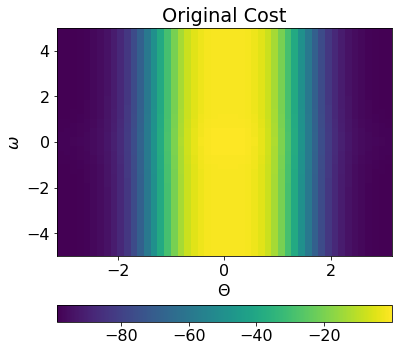

In [30]:
%matplotlib inline
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=[6,6])
im = plt.imshow(cost_matrix.reshape((pendulum.nq, pendulum.nv)), extent=[-np.pi, np.pi, -pendulum.v_max, pendulum.v_max],aspect='auto')
plt.colorbar(im,orientation="horizontal")
plt.xlabel('$\Theta$')
plt.ylabel('$\omega$')
plt.title('Original Cost')

# plt.savefig('actual_cost_function.jpg',dpi=1000,bbox_inches ='tight')

plt.show()

In [ ]:
%matplotlib inline
plt.figure(figsize=[6,6])
im = plt.imshow(value_iteration.policy.reshape((pendulum.nq, pendulum.nv)), extent=[-np.pi, np.pi, -pendulum.v_max, pendulum.v_max], aspect='auto')
plt.colorbar(im)
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Policy')
plt.show()

In [67]:
#Loading Trajectory Data

SH1 = np.load("State_H1.npy")
SH2 = np.load("State_H2.npy")
UH = np.load("Control_H.npy") 

In [68]:
SH = np.reshape(np.array([SH1[1,:],SH2[1,:]]),(299,2))

In [ ]:
# Define the number of features for the inverted pendulum system
num_features = 2  # For the given feature vector

def feature_expectation_from_expert(trajectory,num_features): 

    # Initialize the sum of feature counts
    sum_feature_counts = np.zeros(num_features)

    # Calculate feature expectation
    for iter, s in enumerate(SH):
        #print(state)
        # s = pendulum.get_states(state)
        #u = pendulum.get_input(control_input)
        # Calculate the feature vector for the current state
        features = np.array([
            1-np.exp(-(np.cos(s[0])-1)**2),
            1-np.exp(-(s[1])**2),
        ])
        sum_feature_counts += (0.9**(iter))*features

    # Compute empirical feature expectation
    num_trajectories = 1.0
    e_features = sum_feature_counts / num_trajectories
    
    return(e_features)

e_features = feature_expectation_from_expert(SH,num_features)

print(e_features)

In [75]:
# Define the number of features for the inverted pendulum system
num_features = 2  # For the given feature vector

def feature_expectation_from_trajectories(trajectory,num_features): 

    # Initialize the sum of feature counts
    sum_feature_counts = np.zeros(num_features)

    # Calculate feature counts for each trajectory
    for t in trajectory: 
        for iter, state in enumerate(t.states()):
            #print(state)
            s = pendulum.get_states(state)
            #u = pendulum.get_input(control_input)
            # Calculate the feature vector for the current state
            features = np.array([
                1-np.exp(-(np.cos(s[0])-1)**2),
                1-np.exp(-(s[1])**2),
            ])
            sum_feature_counts += (0.9**(iter))*features

    # Compute empirical feature expectation
    num_trajectories = len(trajectory)
    features = sum_feature_counts / num_trajectories
    
    return(features)

# e_features = feature_expectation_from_trajectories(trajectory,num_features)

# print(e_features)

In [76]:
def cost_descrete_L(ind,pendulum,theta):
    x = pendulum.get_states(ind)
    return theta[0]*(1-np.exp(-(1-np.cos(x[0]))**2)) + theta[1]*(1-np.exp(-(x[1])**2))
    # return theta[0]*np.abs(x[0]) + theta[1]*np.abs(x[1])

In [ ]:
# init = O.Uniform(low=-100.,high=100.)
init = O.Constant(0.0)
optim = O.Sga(lr=O.exponential_decay(lr0=1.0))
omega = init(2)
optim.reset(omega)              # re-start optimizer
eps=1e-1
delta = np.inf

print('omega init:',omega)

while delta > eps:              # iterate until convergence
    omega_old = omega.copy()

    # compute per-state reward from features
    reward = cost_mat(cost_descrete_L,omega)
    # reward = features.dot(omega)

    # compute gradient of the log-likelihood
    VI = ValueIteration_Soft(pendulum,reward,transition_prob)
    VI.iterate(num_iter=2000)
    
    # Compute state visitation frequencies
    trajectory = [pendulum.generate_trajectories(np.array([u1.rvs(),u2.rvs()]), VI.policy, 30) for i in range(1)]
    e_svf = feature_expectation_from_trajectories(trajectory,num_features)
    
    # re-compute detla for convergence check
    delta = np.max(np.abs(e_features-e_svf)/np.abs(e_svf))
    print('delta:',delta)

    grad = e_features - e_svf
    

    # perform optimization step and compute delta for convergence
    optim.step(grad)
    
    print('omega:',omega)

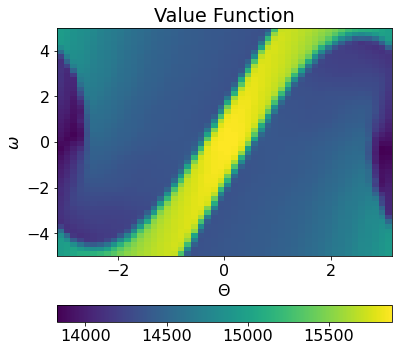

In [119]:
%matplotlib inline
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=[6,6])
im = plt.imshow(VI.value_function.reshape((pendulum.nq, pendulum.nv)), extent=[-np.pi, np.pi, -pendulum.v_max, pendulum.v_max],aspect='auto')
plt.colorbar(im,orientation="horizontal")
plt.xlabel('$\Theta$')
plt.ylabel('$\omega$')
plt.title('Value Function')
plt.show()

# plt.savefig('learned_value_function_bad.jpg',dpi=1000,bbox_inches ='tight')

In [120]:

u1 = st.uniform(loc=-np.pi,scale=0.5)
u2 = st.uniform(loc=-5.,scale=10.)

traj_len = 301
num_traj = 1
X_l = np.zeros((2,traj_len,num_traj))
U_l = np.zeros((traj_len-1,num_traj))
for i in range(num_traj):
    x0 = np.array([u1.rvs(),u2.rvs()])
    x,u = pendulum.simulate(x0, VI.policy, 30)
    X_l[:,:,i] = x
    U_l[:,i] = u

In [121]:
X_l_mean = np.mean(X_l,axis=2)
X_l_std = np.std(X_l,axis=2)

U_mean_l = np.mean(U_l,axis=1)
U_std_l = np.std(U_l,axis=1)

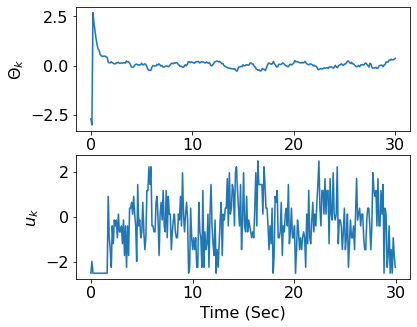

In [122]:
%matplotlib inline
plt.rcParams.update({'font.size': 16})
time = np.linspace(0.,30., len(x[0,:]))
fig, ax = plt.subplots(2,1)
fig.figure.set_figheight(5)
ax[0].plot(time,X_l_mean[0,:].T)
#ax.plot(x,y_FPD)
ax[0].fill_between(time, (X_l_mean[0,:].T-X_std[0,:].T), (X_l_mean[0,:].T+X_l_std[0,:].T), color='b', alpha=.1)
#ax.fill_between(x, (y_FPD-ci_FPD), (y_FPD+ci_FPD), color='b', alpha=.1)
#ax.set_title('FPD input')
# ax[0].set_xlabel('Time (Sec)')
ax[0].set_ylabel('$\Theta_{k}$')

ax[1].plot(time[:-1],U_mean_l[:].T)
#ax.plot(x,y_FPD)
ax[1].fill_between(time[:-1], (U_mean_l[:].T-U_std_l[:].T), (U_mean_l[:].T+U_std_l[:].T), color='b', alpha=.1)
#ax.fill_between(x, (y_FPD-ci_FPD), (y_FPD+ci_FPD), color='b', alpha=.1)
#ax.set_title('FPD input')
ax[1].set_xlabel('Time (Sec)')
ax[1].set_ylabel('$u_{k}$')

#plt.savefig('IHME_Pendulum.jpg',dpi=1000,bbox_inches ='tight')
plt.show()

In [80]:
# Define the number of features for the inverted pendulum system
num_features = 2  # For the given feature vector

def feature_expectation_from_expert(trajectory,num_features): 

    # Initialize the sum of feature counts
    sum_feature_counts = np.zeros(num_features)

    # Calculate feature expectation
    for iter, s in enumerate(SH):
        #print(state)
        # s = pendulum.get_states(state)
        #u = pendulum.get_input(control_input)
        # Calculate the feature vector for the current state
        features = np.array([
            1-np.exp(-(np.cos(s[0])-1)**2),
            1-np.exp(-(s[1])**2),
        ])
        sum_feature_counts += features

    # Compute empirical feature expectation
    num_trajectories = 1.0
    e_features = sum_feature_counts / num_trajectories
    
    return(e_features)

e_features = feature_expectation_from_expert(SH,num_features)

print(e_features)

[18.79638818 29.66023675]


In [ ]:
# Define the number of features for the inverted pendulum system
num_features = 2  # For the given feature vector

def feature_expectation_from_trajectories(trajectory,num_features): 

    # Initialize the sum of feature counts
    sum_feature_counts = np.zeros(num_features)

    # Calculate feature counts for each trajectory
    for t in trajectory: 
        for iter, state in enumerate(t.states()):
            #print(state)
            s = pendulum.get_states(state)
            #u = pendulum.get_input(control_input)
            # Calculate the feature vector for the current state
            features = np.array([
                1-np.exp(-(np.cos(s[0])-1)**2),
                1-np.exp(-(s[1])**2),
            ])
            sum_feature_counts += features

    # Compute empirical feature expectation
    num_trajectories = len(trajectory)
    features = sum_feature_counts / num_trajectories
    
    return(features)

# e_features = feature_expectation_from_trajectories(trajectory,num_features)

# print(e_features)

In [ ]:
# init = O.Uniform(low=-100.,high=100.)
init = O.Constant(0.0)
optim = O.Sga(lr=O.exponential_decay(lr0=1.0))
omega = init(2)
optim.reset(omega)              # re-start optimizer
eps=1e-1
delta = np.inf

print('omega init:',omega)

while delta > eps:              # iterate until convergence
    omega_old = omega.copy()

    # compute per-state reward from features
    reward = cost_mat(cost_descrete_L,omega)
    # reward = features.dot(omega)

    # compute gradient of the log-likelihood
    VI = ValueIteration_Soft(pendulum,reward,transition_prob)
    VI.iterate(num_iter=2000)
    
    # Compute state visitation frequencies
    trajectory = [pendulum.generate_trajectories(np.array([u1.rvs(),u2.rvs()]), VI.policy, 30) for i in range(1)]
    e_svf = feature_expectation_from_trajectories(trajectory,num_features)
    
    # re-compute detla for convergence check
    delta = np.max(np.abs(e_features-e_svf)/np.abs(e_svf))
    print('delta:',delta)

    grad = e_features - e_svf
    

    # perform optimization step and compute delta for convergence
    optim.step(grad)
    
    print('omega:',omega)